In [8]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
from PIL import Image
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPModel, CLIPProcessor
from sklearn.cluster import KMeans

# Get the embeddings

In [4]:
def get_clip_embeddings_and_save(images_folder, embeddings_file):
    processed_imgs = 0
    
    with h5py.File(embeddings_file, 'w') as h5f:  # Open an HDF5 file
        for idx, filename in enumerate(sorted(os.listdir(images_folder))):
            img_path = os.path.join(images_folder, filename)
            img = Image.open(img_path).convert('RGB')

            inputs = processor(images=img, return_tensors="pt").to(device)
            image_features = model.vision_model(**inputs)
            
            # Save the embedding to the HDF5 file
            h5f.create_dataset(name=f'embedding_{idx}', data=image_features[1].cpu().detach().numpy())
            
            processed_imgs += 1

    print(f"Processed {processed_imgs} images in total")

current_directory = os.getcwd()

scene = "scene0000_00"
object_id = 37

images_folder = os.path.join(current_directory, f"outputs/masked_images/project_with_occlusion/{scene}/{object_id}")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

embeddings_folder = os.path.join(current_directory, f"outputs/embeddings/{scene}")
os.makedirs(embeddings_folder, exist_ok=True)
embeddings_file = os.path.join(embeddings_folder, f"{object_id}.hdf5")

get_clip_embeddings_and_save(images_folder, embeddings_file)


Using device: mps


Processed 474 images in total


# Cosine Similarity

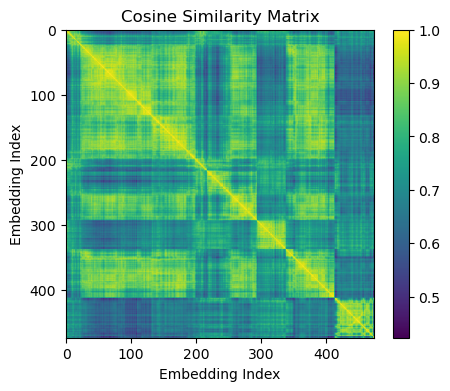

In [9]:
def load_embeddings_from_hdf5(embeddings_file):
    with h5py.File(embeddings_file, 'r') as h5f:
        embeddings = [h5f[f'embedding_{i}'][:] for i in range(len(h5f))]
        embeddings_tensor = torch.tensor(np.stack(embeddings))
    return embeddings_tensor

def calculate_similarity_matrix(embeddings):
    num_embeddings = len(embeddings)
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    
    for i in range(num_embeddings):
        for j in range(num_embeddings):
            if i != j:
                # Flatten the embeddings to 1-D if they are not already
                similarity = 1 - cosine(embeddings[i].flatten(), embeddings[j].flatten())
            else:
                similarity = 1
            similarity_matrix[i, j] = similarity

    return similarity_matrix

def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(5, 4))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

current_directory = os.getcwd()
scene = "scene0000_00"
object_id = 37
embeddings_file = os.path.join(current_directory, f"outputs/embeddings/{scene}/{object_id}.hdf5")

embeddings = load_embeddings_from_hdf5(embeddings_file)

similarity_matrix = calculate_similarity_matrix(embeddings.detach().cpu().numpy())
plot_similarity_matrix(similarity_matrix)


### Thresholding Similarity

You might want to set a threshold for similarity values to identify which image pairs are considered similar or dissimilar. For instance, you could define a high similarity threshold (e.g., >0.8) to find very similar pairs or a low similarity threshold (e.g., <0.3) to find very dissimilar pairs.

In [11]:
def find_similar_embeddings(embedding_index, similarity_matrix, threshold):
    similarity_values = similarity_matrix[embedding_index]
    similar_indices = np.where(similarity_values > threshold)[0]
    return similar_indices

embedding_index = 50
threshold = 0.8
similar_indices = find_similar_embeddings(embedding_index, similarity_matrix, threshold)

print(f"Embeddings similar to {embedding_index}: {similar_indices}")

Embeddings similar to 50: [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 144 146 147 148 150 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 245 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 289 290 291 348 349 350 351 352 353 354
 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372
 373 374 375 376 377 378 

# Cluster Analysis

Use K-Means to group the embeddings into clusters based on their similarity.

Compute Sum of Squared Distances to find optimal K

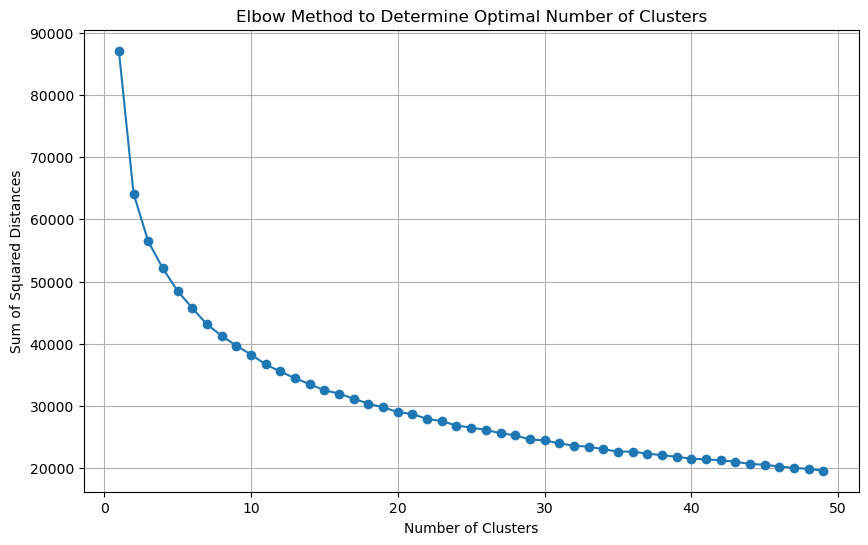

In [13]:
def calculate_sse(embeddings, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
        # Ensure embeddings are 2-dimensional: (n_samples, n_features)
        embeddings_2d = embeddings.reshape(len(embeddings), -1)
        kmeans.fit(embeddings_2d)
        sse.append(kmeans.inertia_)
    return sse

def plot_elbow_curve(k_range, sse):
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.grid(True)
    plt.show()

if isinstance(embeddings, torch.Tensor):
    embeddings_np = embeddings.cpu().detach().numpy()
else:
    embeddings_np = embeddings

k_range = range(1, 50)
sse = calculate_sse(embeddings_np, k_range)
plot_elbow_curve(k_range, sse)


Run K-Means

In [14]:
k = 20  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
embeddings_2d = embeddings_np.reshape(embeddings_np.shape[0], -1)
kmeans.fit(embeddings_2d)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

Embedding 50 belongs to cluster 8
Embedding 254 belongs to cluster 5


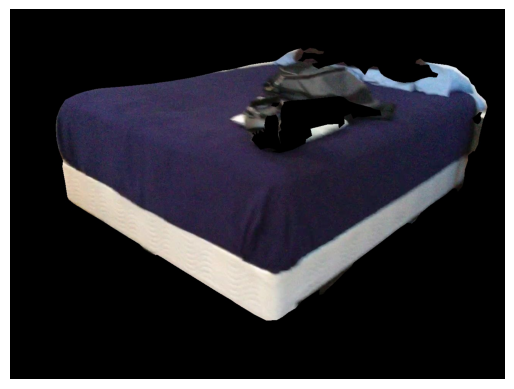

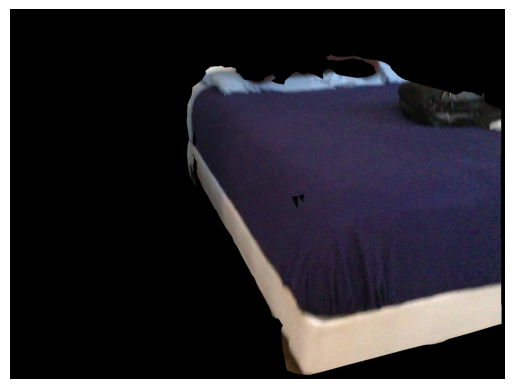

In [17]:
def print_frames_pair(embedding_index_1, embedding_index_2, images_folder):
    for idx, filename in enumerate(sorted(os.listdir(images_folder))):
        if idx == embedding_index_1 or idx == embedding_index_2:
            img_path = os.path.join(images_folder, filename)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

emb_idx_1 = 50
emb_idx_2 = 254

print(f"Embedding {emb_idx_1} belongs to cluster {kmeans.labels_[emb_idx_1]}")
print(f"Embedding {emb_idx_2} belongs to cluster {kmeans.labels_[emb_idx_2]}")
print_frames_pair(emb_idx_1, emb_idx_2, images_folder)

Show labels of each frame

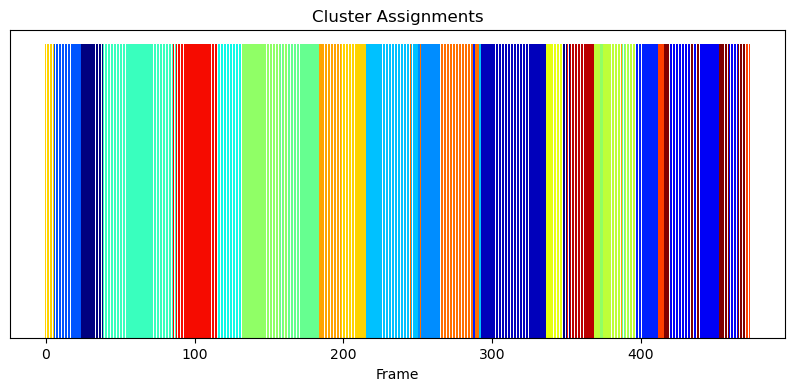

In [18]:
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))
bar_colors = [label_to_color[label] for label in labels]

plt.figure(figsize=(10, 4))
bar_positions = np.arange(len(labels))
plt.bar(bar_positions, np.ones_like(labels), color=bar_colors)

plt.xlabel('Frame')
plt.yticks([])
plt.title('Cluster Assignments')
plt.show()

Show Cosine Similarity Matrix of cluster centers

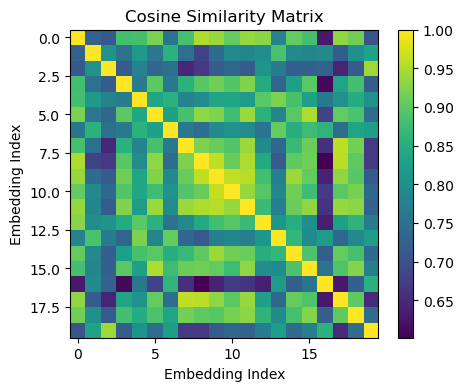

In [19]:
similarity_matrix_center_clusters = cosine_similarity(cluster_centers)
plot_similarity_matrix(similarity_matrix_center_clusters)

Show Cosine Similarity Matrix among one random frame per cluster

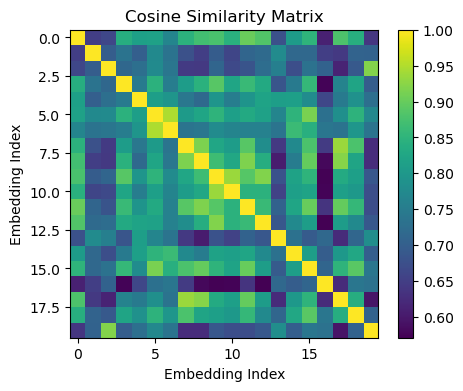

In [20]:
def select_random_frame_per_cluster(embeddings_np, labels, k):
    unique_labels = np.unique(labels)
    selected_frames = []
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_index = np.random.choice(indices)
        selected_frames.append(embeddings_np[selected_index])
    return np.array(selected_frames)


selected_frames = select_random_frame_per_cluster(embeddings_np, labels, k)
similarity_matrix_random_clusters = calculate_similarity_matrix(selected_frames)
plot_similarity_matrix(similarity_matrix_random_clusters)

# Pearson correlation

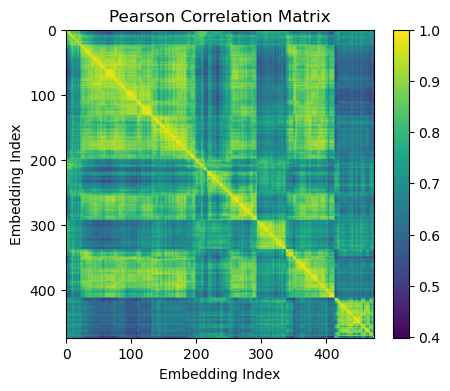

In [21]:
def calculate_pearson_matrix(embeddings):
    num_embeddings = len(embeddings)
    pearson_matrix = np.zeros((num_embeddings, num_embeddings))
    
    for i in range(num_embeddings):
        for j in range(num_embeddings):
            if i != j:
                pearson_matrix[i, j] = np.corrcoef(embeddings[i].flatten(), embeddings[j].flatten())[0, 1]
            else:
                pearson_matrix[i, j] = 1

    return pearson_matrix

def plot_pearson_matrix(pearson_matrix):
    plt.figure(figsize=(5, 4))
    plt.imshow(pearson_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('Pearson Correlation Matrix')
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

current_directory = os.getcwd()
scene = "scene0000_00"
object_id = 37
embeddings_file = os.path.join(current_directory, f"outputs/embeddings/{scene}/{object_id}.hdf5")

embeddings = load_embeddings_from_hdf5(embeddings_file)

pearson_matrix = calculate_pearson_matrix(embeddings.detach().cpu().numpy())
plot_pearson_matrix(pearson_matrix)

is_equal = pearson_matrix == similarity_matrix
